In [1]:
import os
import json
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
%matplotlib inline
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [2]:
# function to return the cv splits by index

def fetch_cv_indicies(X, y, g):
    sgkf = StratifiedGroupKFold(n_splits=10)
    sgkf.get_n_splits(X, y)
    cv_splits = sgkf.split(X, y, g)
        
    return cv_splits


In [3]:
def load_data(data_path, target_labels):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data[target_labels]).astype(int)
    g = np.array(data['fold_label'])

    print("Data successfully loaded!")

    return  X, y, g

In [4]:
mfcc_path = '../data/processed/13_mfcc_5_train.json'

In [5]:
# load data
X, y, g = load_data(data_path=mfcc_path, target_labels='class_label')

Data successfully loaded!


In [6]:
def build_model():
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.1),

        # 2nd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.1),

        # output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser,
                  loss='BinaryCrossentropy',
                  metrics=['binary_accuracy'])
    
    return model

In [7]:
iters = 0
scores = []
devs = []
cum_ave = []

while iters < 50:

    # setup early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    
    # evaluate model with cv splits
    build = build_model()
    model = KerasClassifier(model=build, batch_size=52, epochs=25, random_state=0, verbose=0, callbacks=[callback])

    results = cross_validate(model, X, y, cv=fetch_cv_indicies(X, y, g), n_jobs=-1)
    print(f"{iters+1}) Acc: %.2f%% (%.2f%%)" % (results['test_score'].mean()*100, results['test_score'].std()*100))

    scores.append(results['test_score'].mean()*100)
    devs.append(results['test_score'].std()*100)
    cum_ave.append(np.array(scores).mean())
    
    iters += 1
    
print(f"After {iters} iterations) Baseline: %.2f%% (%.2f%%)" % (np.array(scores).mean(), np.array(devs).mean()))


1) Acc: 94.22% (2.96%)
2) Acc: 91.33% (9.16%)
3) Acc: 94.97% (4.15%)
4) Acc: 92.78% (10.52%)
5) Acc: 93.01% (10.07%)
6) Acc: 91.36% (8.15%)
7) Acc: 93.37% (5.54%)
8) Acc: 96.81% (2.81%)
9) Acc: 92.37% (10.09%)
10) Acc: 92.81% (9.39%)
11) Acc: 94.57% (5.28%)
12) Acc: 94.28% (6.09%)
13) Acc: 90.26% (11.14%)
14) Acc: 95.15% (5.22%)
15) Acc: 93.37% (7.00%)
16) Acc: 95.73% (2.45%)
17) Acc: 95.59% (3.03%)
18) Acc: 96.13% (2.80%)
19) Acc: 97.08% (1.28%)
20) Acc: 95.61% (3.00%)
21) Acc: 92.32% (11.05%)
22) Acc: 94.69% (4.39%)
23) Acc: 95.76% (2.27%)
24) Acc: 94.48% (7.95%)
25) Acc: 92.93% (10.64%)
26) Acc: 96.12% (2.68%)
27) Acc: 95.73% (3.86%)
28) Acc: 91.94% (11.87%)
29) Acc: 94.84% (3.91%)
30) Acc: 95.33% (4.40%)
31) Acc: 93.55% (5.56%)
32) Acc: 95.37% (3.69%)
33) Acc: 94.74% (3.45%)
34) Acc: 94.56% (3.73%)
35) Acc: 95.11% (2.94%)
36) Acc: 91.84% (10.74%)
37) Acc: 94.34% (6.28%)
38) Acc: 92.00% (11.35%)
39) Acc: 94.52% (8.07%)
40) Acc: 93.97% (5.07%)
41) Acc: 91.29% (10.28%)
42) Acc: 95.30%

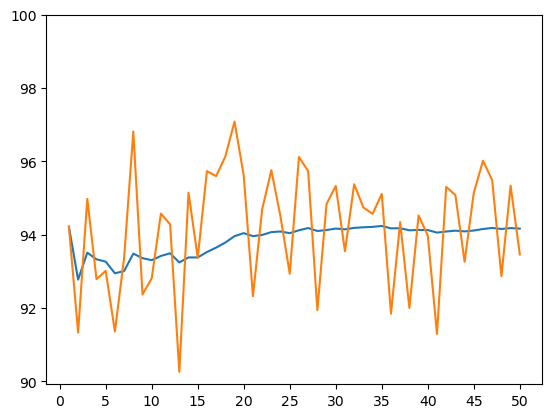

In [8]:
# plot the cumulative average of accuracy
x = range(1, len(scores)+1, 1)
y_cum = cum_ave
plt.plot(x, y_cum)
plt.plot(x, scores)
plt.xticks(range(0, len(scores)+1, 5))
plt.ylim(top=100)
plt.show()

In [9]:
print(f"\nBaseline after {iters} iterations of 10-fold cross-validation:\n\nMean Accuracy: %.2f%% (%.2f%%)\nMean St Dev: (%.2f%%)" % (np.array(scores).mean(), np.array(scores).std(), np.array(devs).mean()))


Baseline after 50 iterations of 10-fold cross-validation:

Mean Accuracy: 94.16% (1.57%)
Mean St Dev: (6.06%)
